In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import time

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


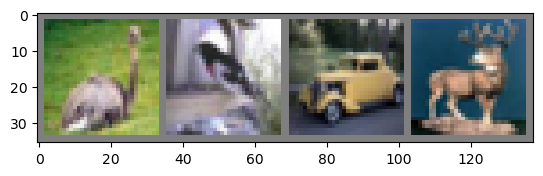

bird  bird  car   deer 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
device = torch.device('cpu')

In [6]:
def train(epoch):
    log_time = time.strftime("%Y%m%d-%H%M%S")
    writer = SummaryWriter('runs/train/' + log_time)
    for epoch in range(epoch):  # loop over the dataset multiple times
        
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                writer.add_scalar('training loss',
                            running_loss / 2000,
                            epoch * len(trainloader) + i)
                running_loss = 0.0

    print('Finished Training')

In [7]:
def test():
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

In [8]:
train(2)
test()

[1,  2000] loss: 2.188
[1,  4000] loss: 1.860
[1,  6000] loss: 1.674
[1,  8000] loss: 1.551
[1, 10000] loss: 1.493
[1, 12000] loss: 1.439
[2,  2000] loss: 1.359
[2,  4000] loss: 1.341
[2,  6000] loss: 1.329
[2,  8000] loss: 1.291
[2, 10000] loss: 1.251
[2, 12000] loss: 1.243
Finished Training
Accuracy of the network on the 10000 test images: 9 %


In [9]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv4 = nn.Conv2d(32, 64, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 5 * 5, 4096)
        self.fc2 = nn.Linear(4096, 1000)
        self.fc3 = nn.Linear(1000, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net2()

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
train(2)
end_time = time.time()
cpu_time = end_time - start_time
test()

[1,  2000] loss: 2.301
[1,  4000] loss: 2.124
[1,  6000] loss: 1.952
[1,  8000] loss: 1.805
[1, 10000] loss: 1.660
[1, 12000] loss: 1.574
[2,  2000] loss: 1.471
[2,  4000] loss: 1.416
[2,  6000] loss: 1.391
[2,  8000] loss: 1.336
[2, 10000] loss: 1.289
[2, 12000] loss: 1.273
Finished Training
Accuracy of the network on the 10000 test images: 10 %


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

cuda:0


In [12]:
net = Net2()
net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [13]:
start_time = time.time()
train(2)
end_time = time.time()
gpu_time = end_time - start_time

print("CPU Time", cpu_time)
print("GPU Time", gpu_time)

[1,  2000] loss: 2.240
[1,  4000] loss: 1.959
[1,  6000] loss: 1.794
[1,  8000] loss: 1.636
[1, 10000] loss: 1.551
[1, 12000] loss: 1.459
[2,  2000] loss: 1.338
[2,  4000] loss: 1.296
[2,  6000] loss: 1.237
[2,  8000] loss: 1.193
[2, 10000] loss: 1.164
[2, 12000] loss: 1.108
Finished Training
CPU Time 960.713297367096
GPU Time 186.6108889579773


In [14]:
def test_top3():
    false_images = []
    false_labels = []
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = net(images.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.topk(outputs.data, 3)
            total += labels.size(0)

            for i in range(labels.size(0)):
                if labels[i] in predicted[i]:
                    correct += 1
                else:
                    false_images.append([inputs[i], labels[i]])

    print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

    return false_images

In [15]:
test()
false_images = test_top3()

Accuracy of the network on the 10000 test images: 9 %
Accuracy of the network on the 10000 test images: 29 %


In [16]:
import random
random_images = random.sample(false_images, 5)
log_time = time.strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter('runs/images/2/' + log_time)

fig = plt.figure()
for i, (img, label) in enumerate(random_images):
    img = img.cpu()
    plt.subplot(1, 5, i + 1)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.title(classes[label])

writer.add_figure("False Images", fig)

In [17]:
from tensorboard import notebook
notebook.display(port=6006, height=1000)